In [ ]:
# Which public health factors have the greatest impact on life expectancy by country 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plot_module as plm

In [2]:
df = pd.read_csv('refined_life_expect.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


In [ ]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)
# plt.savefig('pairedplots_all.png')

In [3]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# children malnutrition, average education, country size (small/medium/big), 
# the ratio between adult to infant mortality, the interactions between bmi+alcohol (lifestyle), 
# and the interaction between population+gdp might effect the life expectancy

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
# corr_map

In [ ]:
# Example 1: Correlation between average education and life expectancy
plm.create_scatter(new_df['school'], new_df['life_expectancy'], 'Life Expectancy and Education', 
                   'Education (Years)', 'Life Expectancy (Years)')         
# np.corrcoef(new_df['school'], new_df['life_expectancy'])

In [ ]:
# Example 2: Correlation between log transformed value of GDP and life expectancy
plm.create_scatter(np.sqrt(new_df['gdp']), new_df['life_expectancy'], 'Life Expectancy and GDP', 
                   'GDP (log)', 'Life Expectancy (Years)') 
# plt.savefig('inf_death_sbrt.png')

In [ ]:
plm.create_hist(new_df['gdp'], transform='log', title="GDP", xlabel="GDP (log)")
# plt.savefig('gdp_hist_after.png')

In [ ]:
# Create a heatmap for all our variables
plm.CorrMtx(corr_map)

In [4]:
# transform our independent variable to look more normally distrubuted
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.gdp = new_df['gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

(1649, 12)

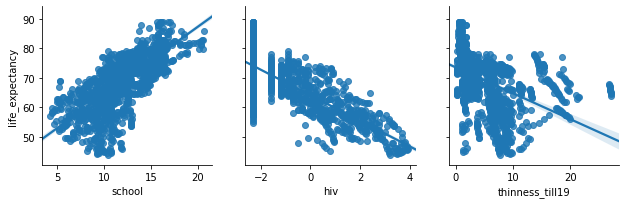

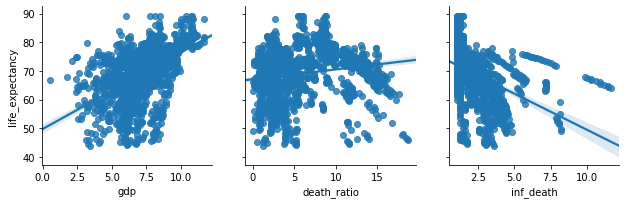

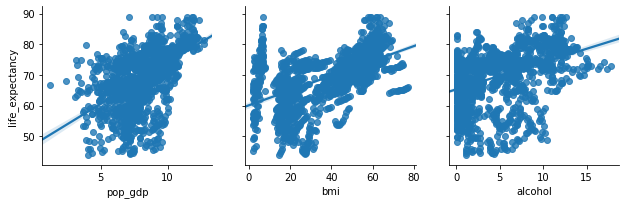

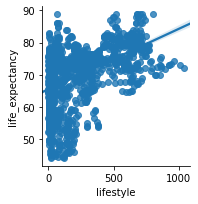

In [5]:
# before running the model we looked at our data more closely to check for outliers
depended = ['life_expectancy']
features = ['school', 'hiv', 'thinness_till19', 'gdp',
            'death_ratio', 'inf_death', 'pop_gdp', 'bmi',
            'alcohol', 'lifestyle'] 

# looking at our data again to try and locate outliers
plm.get_pairs(new_df, depended, features, 3, fig_name="paired_before.png")
new_df.shape

(1635, 12)

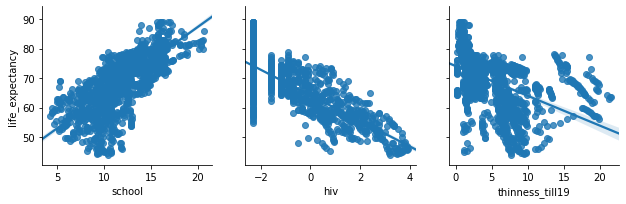

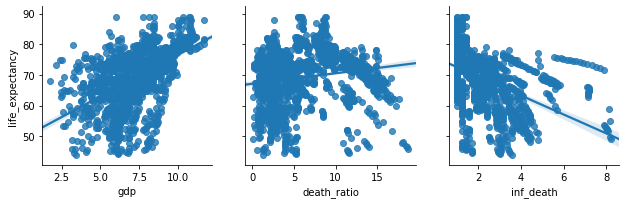

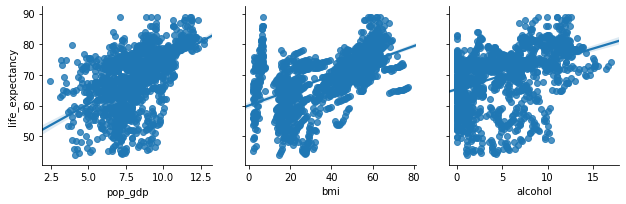

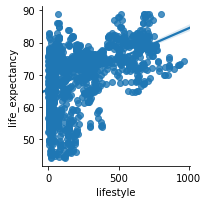

In [6]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.gdp > 1.25] 
new_df = new_df[new_df.thinness_till19 < 25]
new_df = new_df[new_df.lifestyle < 1000]

plm.get_pairs(new_df, depended, features, 3, fig_name="paired_after.png")
new_df.shape

In [ ]:
# Using seaborn to create scatters and distribution graphs for our possible predictors after transforming the data
colors = ['red','blue','green','black','purple','orange','pink', 'cyan','maroon', 'gray']
count = 0 
for column in new_df.columns[1:-1]:
    plots = sns.jointplot(x=column, y='life_expectancy', data=new_df, kind='reg', ylim=(0,140), color=colors[count])
    plots.annotate(stats.pearsonr)
    count += 1

In [ ]:
# first model to test our feature's significance
lr_model_init = ols(formula='life_expectancy~bmi+hiv+gdp+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model_init.summary()

In [ ]:
 plm.checkresiduals(new_df, 'life_expectancy', lr_model_init)

In [ ]:
#adjusting the model - remove features that were not statistically significant (alcohol, bmi, lifestyle)
lr_model_inter = ols(formula='life_expectancy~+hiv+gdp+thinness_till19+inf_death+school+death_ratio+pop_gdp+C(pop_size)', data=new_df).fit()
lr_model_inter.summary()

In [ ]:
plm.checkresiduals(new_df, 'life_expectancy', lr_model_inter)

In [10]:
# Scaling the data set
independent = ['school', 'hiv', 'thinness_till19',
               'death_ratio', 'inf_death', 'pop_gdp',
               ] 

scaler = StandardScaler()
scaler.fit(new_df[independent])
scaled_features = scaler.transform(new_df[independent])

# create a scaled dataframe
scaled_features_df = pd.DataFrame(scaled_features, columns=independent, index=new_df.index)
scaled_features_df.head()

# running the model again
scaled_features_model = sm.OLS(endog=new_df['life_expectancy'], exog=sm.add_constant(scaled_features_df)).fit()
scaled_features_model.summary()

c:\users\gilor\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1107.
Date:                Fri, 23 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:56:02   Log-Likelihood:                -4552.1
No. Observations:                1635   AIC:                             9118.
Df Residuals:                    1628   BIC:                             9156.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              69.3221      0.097    714.154      0.000      69.132      69.513
school              2.5658      0.148     17.357      0.000       2.276       2.856
hiv                -4.8548      0.114    -42.584      0.000      -5.078      -4.631
thinness_till19    -0.6430      0.116     -5.552      0.000      -0.870      -0.416
death_ratio        -0.9264      0.132     -6.994      0.000      -1.186      -0.667
inf_death          -1.3774      0.152     -9.091      0.000      -1.675      -1.080
pop_gdp             0.9866      0.122      8.084      0.000       0.747       1.226
==============================================================================
Omnibus:                       12.292   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.294
Skew:                          -0.047   Prob(JB):                     0.000176
Kurtosis:                       3.495   Cond. No.                         3.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

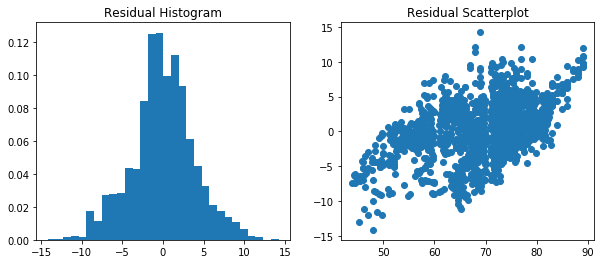

In [11]:
plm.checkresiduals(new_df, 'life_expectancy', scaled_features_model)

Mean absolete error: 3.082329962751478
Mean squared error: 16.944079751915773
Root squared error: 4.116318713597839


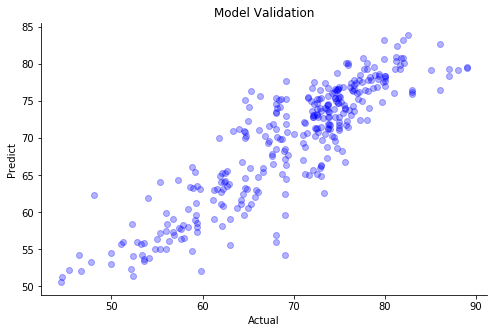

In [13]:
# removing bmi, gdp, population size from testing that were deemed insignificant in past models
X = new_df[['hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)
# print(model.intercept_)
# print(model.coef_)

y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predict.flatten()})
plot_df = predict_df.head(1530)
# plot_df.plot(kind='scatter', x='Actual', y='Predicted', figsize=(8,5))
# plt.ylabel('Life Expectancy')
# plt.xlabel('Obvservation')

plm.create_scatter(plot_df.Actual, plot_df.Predicted, 'Model Validation', 'Actual', 'Predict')
plt.savefig('model_final.png')

print('Mean absolete error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('Root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

Mean absolete error: 3.053876023766805
Mean squared error: 16.751239699146097
Moot squared error: 4.092827836489839


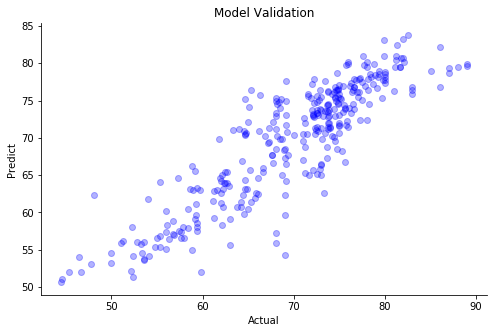

In [16]:
# adding the features that were considered insignificant to our model to test
X2 = new_df[['alcohol','bmi', 'pop_size', 'hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y2 = new_df.life_expectancy.values.reshape(-1,1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train2, y_train2)
# print(model.intercept_)
# print(model.coef_)

y_predict2 = model.predict(x_test2)
predict_df2 = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': y_predict2.flatten()})
plot_df2 = predict_df2.head(1530)
# plot_df2.plot(kind='bar', figsize=(8,5))
# plt.ylabel('Life Expectancy')
# plt.xlabel('Obvservation')

plm.create_scatter(plot_df2.Actual, plot_df2.Predicted, 'Model Validation', 'Actual', 'Predict')
plt.savefig('model_all.png')

print('Mean absolete error:', metrics.mean_absolute_error(y_test2, y_predict2))
print('Mean squared error:', metrics.mean_squared_error(y_test2, y_predict2))
print('Moot squared error:', np.sqrt(metrics.mean_squared_error(y_test2, y_predict2)))